In [5]:
def load_labels_from_file(label_file):
    with open(label_file, 'r') as f:
        labels = [int(line.strip()) for line in f if line.strip()]
    return labels

train_labels_file = r'C:\Users\USER\Downloads\mnist\train-labels.txt'
test_labels_file = r'C:\Users\USER\Downloads\mnist\t10k-labels.txt'

train_labels = load_labels_from_file(train_labels_file)
test_labels = load_labels_from_file(test_labels_file)

print("Loaded train labels:", len(train_labels))
print("Loaded test labels:", len(test_labels))


Loaded train labels: 60000
Loaded test labels: 10000


In [40]:

def count_unique_classes(labels):
    unique_classes = set(labels)
    return unique_classes


# Count unique classes in train and test labels
unique_classes_train = count_unique_classes(train_labels)
unique_classes_test = count_unique_classes(test_labels)

print("Number of unique classes in train labels:", len(unique_classes_train))
print("Unique classes in train labels:", unique_classes_train)

print("Number of unique classes in test labels:", len(unique_classes_test))
print("Unique classes in test labels:", unique_classes_test)


Number of unique classes in train labels: 10
Unique classes in train labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Number of unique classes in test labels: 10
Unique classes in test labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [12]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

def load_images_from_folder(folder, num_images):
    images = []
    for i in range(num_images):
        img_path = os.path.join(folder, f"{i:05d}.png")  # Adjust the format specifier as needed
        if os.path.exists(img_path):
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (28, 28))
            images.append(image)
        else:
            print(f"Image {img_path} not found.")
            break
    return np.array(images)

train_images_folder = r'C:\Users\USER\Downloads\mnist\train-images'
test_images_folder = r'C:\Users\USER\Downloads\mnist\t10k-images'

# Assuming you have already loaded `train_labels` and `test_labels` correctly

# Load training and testing images
x_train = load_images_from_folder(train_images_folder, len(train_labels))
x_test = load_images_from_folder(test_images_folder, len(test_labels))

# Ensure the number of images matches the number of labels
assert len(x_train) == len(train_labels), "Mismatch between number of training images and labels"
assert len(x_test) == len(test_labels), "Mismatch between number of testing images and labels"

y_train = np.array(train_labels)
y_test = np.array(test_labels)

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Expand dimensions to match the expected input shape of the CNN (28, 28, 1)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Convert labels to categorical one-hot encoding
num_classes = len(np.unique(np.concatenate((y_train, y_test), axis=0)))
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


x_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 10)
x_test shape: (10000, 28, 28, 1)
y_test shape: (10000, 10)


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the input shape
input_shape = (28, 28, 1)

# Define the CNN model
model = Sequential([
    Input(shape=input_shape),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=128, 
                    verbose=1, callbacks=[checkpoint, early_stopping])

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

# Print comprehensive results
print("\n--- Training Results ---")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Best Training Accuracy: {max(history.history['accuracy']):.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")

print("\n--- Test Results ---")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Calculate and print confusion matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.close()

print("\nConfusion matrix saved as 'confusion_matrix.png'")

# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.close()

print("Training history plot saved as 'training_history.png'")

# Save the final model
model.save(r'C:\Users\USER\Downloads\mnist\final_model.keras')
print("\nFinal model saved as 'final_model.keras'")

Epoch 1/50
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7689 - loss: 0.7334
Epoch 1: val_accuracy improved from -inf to 0.97625, saving model to best_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.7696 - loss: 0.7314 - val_accuracy: 0.9762 - val_loss: 0.0784
Epoch 2/50
373/375 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9644 - loss: 0.1203
Epoch 2: val_accuracy improved from 0.97625 to 0.98392, saving model to best_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9645 - loss: 0.1203 - val_accuracy: 0.9839 - val_loss: 0.0519
Epoch 3/50
373/375 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9745 - loss: 0.0838
Epoch 3: val_accuracy improved from 0.98392 to 0.98617, saving model to best_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9746 - loss: 0.0838 - val_accuracy: 0.9862 - val_loss: 0.0452
Epoch 4/50
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9802 - loss: 0.0620
Epoch 4: val_accuracy improved fro

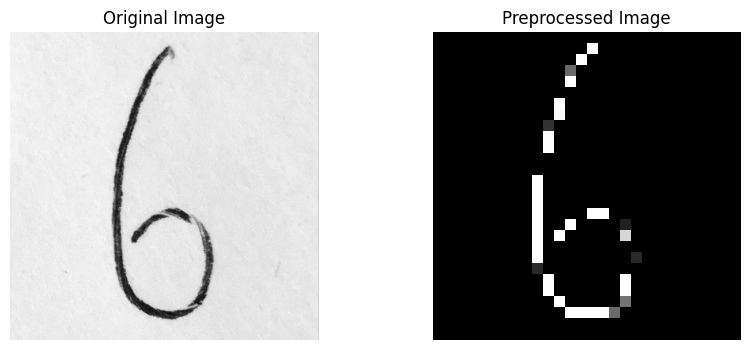

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Predicted class: 6
Confidence: 0.75


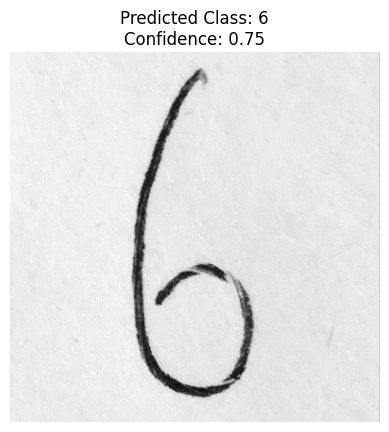

In [118]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
model = load_model(r'C:\Users\USER\Downloads\mnist\final_model.keras')

def preprocess_image(img_path):
    # Load the image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Check the average pixel intensity to decide whether to invert colors
    avg_intensity = np.mean(img)
    
    if (avg_intensity > 128):
        # Apply binary thresholding to invert the colors if the background is white
        _, img_thresh = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)
    else:
        img_thresh = img

    # Resize the image
    img_resized = cv2.resize(img_thresh, (28, 28))
    
    # Normalize the image
    img_normalized = img_resized / 255.0
    
    # Add a batch dimension
    img_expanded = np.expand_dims(img_normalized, axis=[0, -1])
    
    # Visualize the original and preprocessed images
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_resized, cmap='gray')
    plt.title('Preprocessed Image')
    plt.axis('off')
    
    plt.show()
    
    return img_expanded

def predict_image(img_path):
    # Preprocess the image
    processed_image = preprocess_image(img_path)
    
    # Make prediction
    prediction = model.predict(processed_image)
    
    # Get the predicted class
    predicted_class = np.argmax(prediction)
    
    # Get the confidence
    confidence = np.max(prediction)
    
    return predicted_class, confidence

def display_image_and_prediction(img_path, predicted_class, confidence):
    # Load and display the image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
    plt.show()

# Test the model with a provided image
img_path = r"C:\Users\USER\Downloads\test12.jpg"

try:
    predicted_class, confidence = predict_image(img_path)
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}")
    
    display_image_and_prediction(img_path, predicted_class, confidence)
except Exception as e:
    print(f"An error occurred: {str(e)}")
